<a href="https://colab.research.google.com/github/thomas-c-reid/TensorflowDeepLearning/blob/master/13_Time_series_forecasting_using_LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

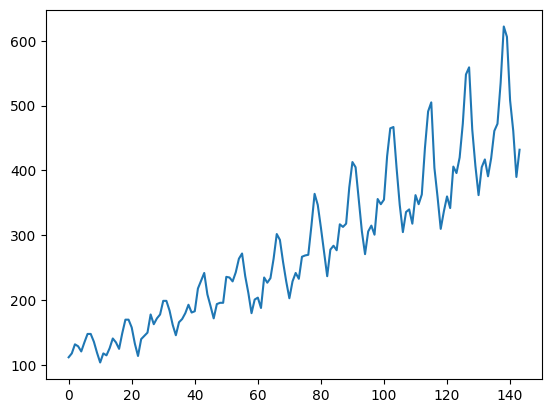

In [16]:
dataframe = pd.read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

In [17]:
dataset = dataframe.values
dataset = dataset.astype("float32")

scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [18]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [19]:
seq_size = 10

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


**MODEL**

In [32]:
# Single LTSM with Hidden Dense layer

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                19200     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Stacked LTSM 



# modelStacked = Sequential()
# modelStacked.add(LSTM(64, activation="relu", return_sequences=True, input_shape=(None, seq_size)))
# modelStacked.add(LSTM(64, activation="relu"))
# modelStacked.add(Dense(32))
# modelStacked.add(Dense(1))
# modelStacked.compile(loss="mean_squared_error", optimizer="adam")
# modelStacked.summary()

In [33]:
model.fit(trainX, trainY, validation_data=(testX,testY),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0649 - val_loss: 0.2854 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0392 - val_loss: 0.1816 - 69ms/epoch - 23ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0211 - val_loss: 0.1062 - 42ms/epoch - 14ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0114 - val_loss: 0.0557 - 41ms/epoch - 14ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0077 - val_loss: 0.0299 - 40ms/epoch - 13ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0080 - val_loss: 0.0221 - 63ms/epoch - 21ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0098 - val_loss: 0.0210 - 43ms/epoch - 14ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0209 - 47ms/epoch - 16ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0087 - val_loss: 0.0222 - 44ms/epoch - 15ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0071 - val_loss: 0.0262 - 46ms/epoch - 15ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0061 - val_loss: 0.0315 - 46ms/epoch - 15ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0058 - val_loss: 0.0354 - 43ms/epoch - 14ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0060 - va

In [34]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 1s 735ms/step


In [35]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [36]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.67 RMSE
Test Score: 38.31 RMSE


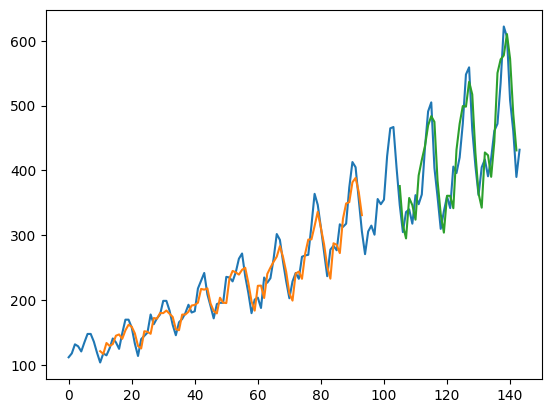

In [37]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()